In [20]:
using CSV
using DataFrames
using Distributions
using StatsBase
using PythonPlot
using Random
using Tables
using DifferentialEquations
include("./../src/GrowthTraceTools.jl")
using .GrowthTraceTools

In [21]:
pred_dir = "./../src/output/output_8-29-24"
pred_df = CSV.read(pred_dir*"/preds.csv",DataFrame);
lineages = unique(pred_df.lineage)

7-element Vector{Float64}:
  1.0
  2.0
  4.0
  5.0
  6.0
 14.0
 22.0

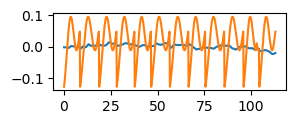

In [22]:
d = pred_df[pred_df.lineage .==lineages[2],:]
data_cells = combine(groupby(d,:position),:matern32_flucs_x=>mean=>:gr,:time=>(x->x[end]-x[1])=>:gt)
data_cells[data_cells.gt .> 0,:];
fig, ax = subplots(figsize=(3,1))
ax.plot(d.time,d.matern32_flucs_x)
ax.plot(d.time,d.matern32_cell_x)
fig

# Fit to OU process

In [38]:
# first lambda_i to AR1 process
t = d[:,:time]
dt = mean(diff(t))
x = d[1:5:end,:matern32_flucs_x]
X = hcat(ones(length(x)-1),x[1:end-1])
y = x[2:end]
b = X\y
v = mean((X*b .- y) .^2)

# b[1] = lambda_0 (1-e^{-dt/tau}) ~ lambda_0dt/tau
# b[2] = e^{-dt/tau} ~ 1-dt/tau
# v = D*tau*(1-e^{-2dt/tau}) ~ D*tau*2*dt/tau
τ =  dt/(1-b[2])
τ
D = v/2/dt

5.27805920604441e-5

In [39]:
sqrt(v)

0.004594805417444533

# Run simulations

In [40]:
θ = (
    Δ = 40.0,       
    σDN = 0.00,         # noise injected at division 
    τ = τ,            
    D = D,      # note that if σDN >0 we will want to adjust this
    λ0 = 0.07,          # average growth rate       
    σM = sqrt(40.0)
    )
init = [θ.Δ,θ.λ0,2*θ.Δ,0]
θ

(Δ = 40.0, σDN = 0.0, τ = 0.5849813647502197, D = 5.27805920604441e-5, λ0 = 0.07, σM = 6.324555320336759)

In [41]:

# -----------------------------------------------------------
# build model and run 
prob,callback,names = GrowthTraceTools.build_model_OU(θ,init,t)
sol = solve(prob,callback = callback);

# -----------------------------------------------------------
# put in dataframe 
df = GrowthTraceTools.solver_output_to_dataframe(sol,names)
df = df[df.position .< max(df.position...),:]
df_cells = combine(groupby(df,:position),:λ=>mean=>:gr,:M=>(x->x[1])=>:M0,:time=>(x->x[end]-x[1])=>:gt)
df_cells[df_cells.gt .> 0,:];

# Compare to data

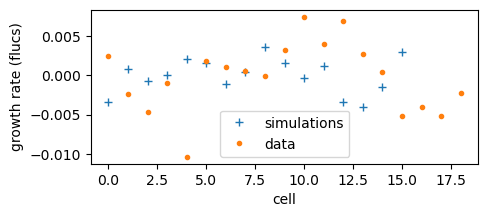

In [42]:
fig,ax = subplots(figsize=(5,2))
ax.plot(df_cells.gr .- mean(df_cells.gr),"+",label="simulations")
ax.plot(data_cells.gr,".",label="data")
ax.set_xlabel("cell")
ax.set_ylabel("growth rate (flucs)")
ax.legend(frameon=true)
fig

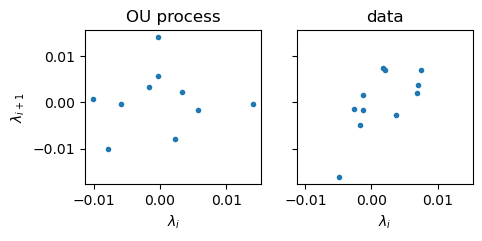

In [27]:
fig,axs = subplots(figsize=(5,2),ncols=2,sharey=true,sharex=true)
y = df_cells.gr .- mean(df_cells.gr)
axs[0].set_title("OU process")
axs[0].plot(y[1:end-1],y[2:end],".")
axs[0].set_xlabel(L"$\lambda_i$")
axs[0].set_ylabel(L"$\lambda_{i+1}$")

axs[1].set_title("data")
axs[1].plot(data_cells.gr[1:end-1],data_cells.gr[2:end],".")
axs[1].set_xlabel(L"$\lambda_i$")
fig

# Perform fit on all lineages

In [69]:
vars_sims = []
vars_data = []
for lin in lineages

    # get lineage 
    d = pred_df[pred_df.lineage .==lin,:]

    # get cells
    data_cells = combine(groupby(d,:position),:matern32_flucs_x=>mean=>:gr,:time=>(x->x[end]-x[1])=>:gt)
    push!(vars_data,var(data_cells.gr))

    #
    # fit lambda_i to AR1 process
    t = d[:,:time]
    dt = mean(diff(t))
    x = d[1:1:end,:matern32_flucs_x]
    X = hcat(ones(length(x)-1),x[1:end-1])
    y = x[2:end]
    b = X\y
    v = mean((X*b .- y) .^2)

    τ =  dt/(1-b[2])
    D = v/2/dt
    θ = (Δ = 60.0,σDN = 0.0,τ = τ,D = D,λ0 = 0.07,σM = sqrt(30.0))
    init = [θ.Δ,θ.λ0,2*θ.Δ,0]


    # -----------------------------------------------------------
    # build model and run 
    prob,callback,names = GrowthTraceTools.build_model_OU(θ,init,t)
    sol = solve(prob,callback = callback);
    println(length(data_cells.gr))
    # -----------------------------------------------------------
    # put in dataframe 
    df = GrowthTraceTools.solver_output_to_dataframe(sol,names)
    df = df[df.position .< max(df.position...),:]
    df_cells = combine(groupby(df,:position),:λ=>mean=>:gr,:M=>(x->x[1])=>:M0,:time=>(x->x[end]-x[1])=>:gt)
    df_cells[df_cells.gt .> 0,:];
    push!(vars_sims,var(df_cells.gr))
end



12
12
12
22
23
29
19


sys:1: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.


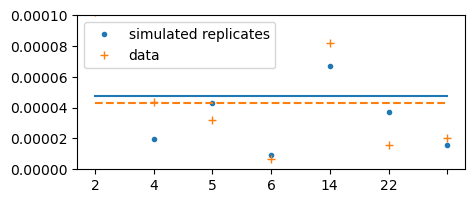

In [68]:
fig, ax = subplots(figsize=(5,2))
ax.plot(vars_sims,"C0.",label="simulated replicates")
ax.plot(vars_data,"C1+",label="data")
ax.plot(ones(length(vars_data)) .* mean(vars_data),"C1--")
ax.plot(ones(length(vars_sims)) .* mean(vars_sims),"C0-")
ax.legend(frameon=true)
ax.set_ylim([0,0.0001])
ax.set_xticklabels([Int64(l) for l in sort(lineages)])
fig

In [61]:
mean(vars_sims)

0.00021887877022914938

In [62]:
mean(vars_data)

4.309901527024254e-5